# Powerlifting Data Science Project: Analysis Notebook

## Imports and Setup

In [117]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import statsmodels.stats.oneway as sm_ow

## 1. Introduction

Powerlifting is a strength sport in which competitors attempt to lift the maximum possible weight in three standardized movements across: the squat, bench press, and deadlift, in multiple attempts. Performance is evaluated by the total (TotalKg) sum of the maximum weight completed for each of the three lifts. Powerlifters compete in weight classes, with their rankings being evaluated based on the performance of other competitors of the same weight class.

A classic metric for measuring powerlifting performance directly between weight classes is the Wilks score, using a function that takes a competitors Total and bodyweight as inputs, and outputs their Wilks score.

The Wilks score is calculated by multiplying an athlete’s total weight lifted by a scaling factor derived from bodyweight. Specifically, the Wilks formula takes the form:
Wilks Score = (500 × TotalKg) / (a + bW + cW² + dW³ + eW⁴ + fW⁵)
where `W` is the athlete’s bodyweight in kilograms and the coefficients `a`–`f` differ by sex. This formulation allows performances across different bodyweights to be compared on a common relative-strength scale.

Despite widespread use of Wilks scores in competition, important questions remain about how performance differs across sexes, weight classes, and individual lifts, and how strongly bodyweight influences performance outcomes. Understanding these relationships provides insight into competitive fairness, performance scaling, and the limitations of bodyweight-adjusted metrics.

This notebook uses data from the Open Powerlifting Database to explore performance patterns among adult raw competitors. Using a combination of descriptive statistics, hypothesis testing, correlation analysis, and linear regression, the analysis addresses four key questions:
1. Whether Wilks scores differ between male and female competitors
2. Whether total weight lifted differs across bodyweight classes
3. How strongly bodyweight is associated with performance in each competition lift
4. How lift performance changes, on average, with increasing bodyweight

Together, these analyses provide a data-driven view of how bodyweight relates to strength performance in competitive powerlifting.

---

The analysis focuses exclusively on raw (unequipped) powerlifting performances, the most common and accessible variant of this sport.

This notebook documents the complete analytical workflow for the project, including:

1) Data loading and inspection
2) Data cleaning and preprocessing
3) Exploratory data analysis (EDA)
4) Assumption testing (normality and homogeneity)
5) Inferential statistical analyses:
   - Independent-samples t-test
   - One-way ANOVA
   - Correlation analysis
   - Regression modeling
6) Visualizations supporting both exploratory and inferential findings

Dataset source (Kaggle): https://www.kaggle.com/datasets/open-powerlifting/powerlifting-database/data

## 2. Data Cleaning and Preprocessing

The raw Open Powerlifting dataset is loaded from `archive/openpowerlifting.csv`.

In [12]:
ARCHIVE_PATH = "archive/openpowerlifting.csv"

df_raw = pd.read_csv(ARCHIVE_PATH, low_memory=False)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 37 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Name             1423354 non-null  object 
 1   Sex              1423354 non-null  object 
 2   Event            1423354 non-null  object 
 3   Equipment        1423354 non-null  object 
 4   Age              757527 non-null   float64
 5   AgeClass         786800 non-null   object 
 6   Division         1415176 non-null  object 
 7   BodyweightKg     1406622 non-null  float64
 8   WeightClassKg    1410042 non-null  object 
 9   Squat1Kg         337580 non-null   float64
 10  Squat2Kg         333349 non-null   float64
 11  Squat3Kg         323842 non-null   float64
 12  Squat4Kg         3696 non-null     float64
 13  Best3SquatKg     1031450 non-null  float64
 14  Bench1Kg         499779 non-null   float64
 15  Bench2Kg         493486 non-null   float64
 16  Bench3Kg         4

An analysis-ready dataset was created from the original Open Powerlifting Database using the following steps:

- Because official powerlifting results are determined by the best successful attempt for each lift, individual attempt-level variables (e.g., first attempts) are not required for this analysis and were removed.
- Restricted the dataset to **raw (unequipped) powerlifting performances** to reduce inconsistencies introduced by supportive equipment
- Removed records with missing values in key fields used for analysis
- Excluded observations containing implausible values (e.g., BodyweightKg ≤ 0 or TotalKg ≤ 0)
- Filtered to adult competitors (Age ≥ 18 when age information was available)

For this analysis, we restrict the dataset to adult powerlifters competing in standard open weight classes. Bodyweights below 40 kg were excluded because they fall outside typical adult competitive categories and are likely to represent youth or non-comparable populations.

Bodyweight and lift values in the Open Powerlifting Database are standardized and reported in kilograms (kg).

The resulting cleaned dataset was saved as `data/openpowerlifting_cleaned.csv` and used for all subsequent statistical analyses.

In [120]:
os.makedirs("data", exist_ok=True)

keep_cols = [
    "Sex","Equipment","Wilks","WeightClassKg","TotalKg","BodyweightKg",
    "Best3SquatKg","Best3BenchKg","Best3DeadliftKg","Age",
]

df = df_raw.loc[:, keep_cols].copy()

# Filters
df = df[df["Equipment"] == "Raw"]
df = df[df["Age"].isna() | (df["Age"] >= 18)]  # matches your original behavior


# Drop missing required values
required = ["Sex","Wilks","WeightClassKg","TotalKg","BodyweightKg",
            "Best3SquatKg","Best3BenchKg","Best3DeadliftKg"]
df = df.dropna(subset=required)

# Remove implausible or irrelevant values, as well as implausibly low bodyweights unlikely to represent adult competitors
# with minimum weights
df = df[(df["BodyweightKg"] > 0) & (df["TotalKg"] > 0)]
df = df[(df["Best3SquatKg"] > 0) & (df["Best3BenchKg"] > 0) & (df["Best3DeadliftKg"] > 0)]
df = df[df["BodyweightKg"] >= 40]


# Equipment row unnecessary because only the 'Raw' category will be recorded
df = df.drop(columns=["Equipment"])

CLEAN_PATH = "data/openpowerlifting_cleaned.csv"
df.to_csv(CLEAN_PATH, index=False)

summary_stats = df[["TotalKg", "BodyweightKg"]].agg(["min", "max"])
summary_stats




,TotalKg,BodyweightKg
min,60.0,40.0
max,1112.5,233.0


Totals greater than zero were retained, as low totals can reflect valid competition performances among novice or lightweight competitors.

In addition, records with missing age were also retained, provided there was no evidence that the competitor was under 18 and minimum bodyweight standards as mentioned above were met.

In [14]:
df_clean = pd.read_csv(CLEAN_PATH)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248109 entries, 0 to 248108
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Sex              248109 non-null  object 
 1   Wilks            248109 non-null  float64
 2   WeightClassKg    248109 non-null  object 
 3   TotalKg          248109 non-null  float64
 4   BodyweightKg     248109 non-null  float64
 5   Best3SquatKg     248109 non-null  float64
 6   Best3BenchKg     248109 non-null  float64
 7   Best3DeadliftKg  248109 non-null  float64
 8   Age              188072 non-null  float64
dtypes: float64(7), object(2)
memory usage: 17.0+ MB


## 3. Exploratory Data Analysis (EDA)

Exploratory visualizations is conducted to evaluate data completeness and summarize key numerical variables before proceeding to statistical testing.

These descriptive plots are intended to provide context for subsequent analyses.


In [15]:
eda_cols = [
    "Sex", "Equipment", "Age", "BodyweightKg", "WeightClassKg",
    "Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg",
    "TotalKg", "Wilks"
]

df_raw[eda_cols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Sex              1423354 non-null  object 
 1   Equipment        1423354 non-null  object 
 2   Age              757527 non-null   float64
 3   BodyweightKg     1406622 non-null  float64
 4   WeightClassKg    1410042 non-null  object 
 5   Best3SquatKg     1031450 non-null  float64
 6   Best3BenchKg     1276181 non-null  float64
 7   Best3DeadliftKg  1081808 non-null  float64
 8   TotalKg          1313184 non-null  float64
 9   Wilks            1304407 non-null  float64
dtypes: float64(7), object(3)
memory usage: 108.6+ MB


Several variables (e.g., Age and attempt-level lift data) contain substantial missing values and were treated accordingly during preprocessing.


## Descriptive Statistics

In [121]:
total_stats = df["TotalKg"].agg(
    Mean="mean",
    Median="median",
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75),
    Min="min",
    Max="max"
)

total_stats["IQR"] = total_stats["Q3"] - total_stats["Q1"]
total_stats


Mean       466.136628
Median     475.000000
Q1         330.000000
Q3         580.000000
Min         60.000000
Max       1112.500000
IQR        250.000000
Name: TotalKg, dtype: float64

#### Interpretation

The mean total weight lifted (466 kg) is slightly lower than the median (475 kg), indicating a right-skewed distribution. The interquartile range of 250 kg (Q1 = 330 kg, Q3 = 580 kg) shows substantial variability among typical competitors, while the wide overall range reflects the presence of extreme high-end performances.”

### Distribution of Total Weight Lifted
A histogram of total weight lifted is used to summarize the overall distribution of performance levels across competitors.


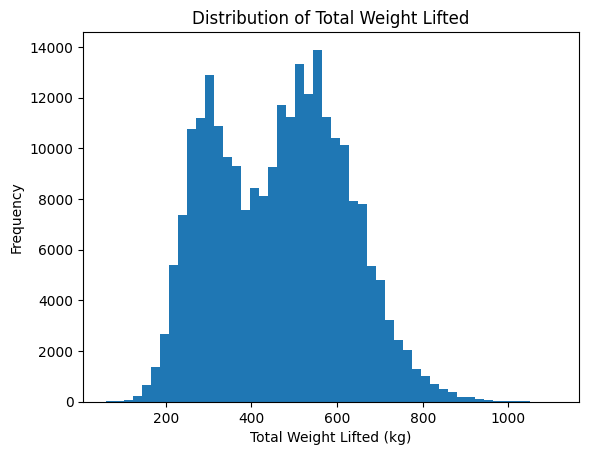

In [16]:
plt.figure()
plt.hist(df_clean["TotalKg"], bins=50)
plt.xlabel("Total Weight Lifted (kg)")
plt.ylabel("Frequency")
plt.title("Distribution of Total Weight Lifted")
plt.show()

#### Intepretation

The distribution of total weight lifted is right-skewed, with most observations concentrated in the midrange and a long tail extending toward very high totals. The histogram shows two areas of higher density, resembling overlapping normal distributions, suggesting that the sample may reflect multiple underlying subpopulations. Given the focus on sex-based differences in total lifts in this study, this motivates examining distributions stratified by sex in subsequent in this analysis.

### Bodyweight and Total Performance

A scatter plot is used to explore the relationship between competitor bodyweight and total weight lifted.

This plot reflects the cleaned analysis dataset after applying all preprocessing filters described above (including the adult bodyweight threshold).

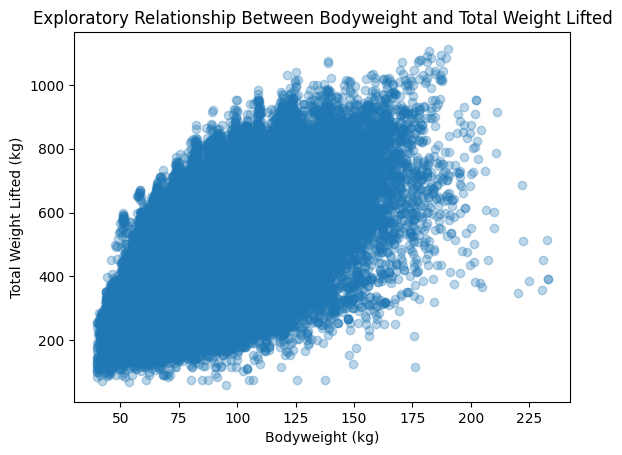

In [122]:
mask = df_clean["BodyweightKg"] >= 40

plt.figure()
plt.scatter(
    df_clean.loc[mask, "BodyweightKg"],
    df_clean.loc[mask, "TotalKg"],
    alpha=0.3
)
plt.xlabel("Bodyweight (kg)")
plt.ylabel("Total Weight Lifted (kg)")
plt.title("Exploratory Relationship Between Bodyweight and Total Weight Lifted")
plt.show()


#### Interpretation

The scatterplot shows a clear positive and approximately linear relationship between bodyweight and total weight lifted, with variability increasing at higher bodyweights

#### Wilks Scores by Sex

A boxplot of Wilks scores by sex is used to provide an initial visual comparison of relative strength distributions between groups.


<Figure size 640x480 with 0 Axes>

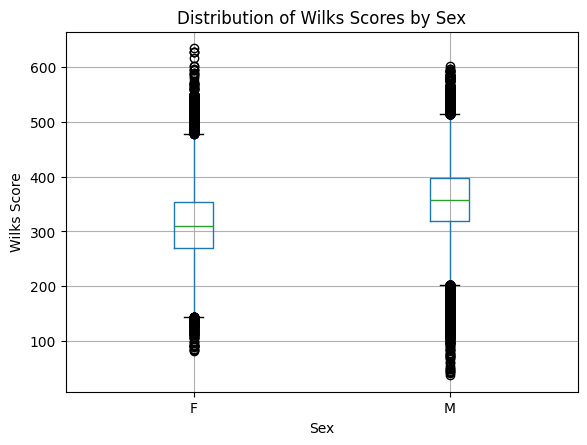

In [18]:
plt.figure()
df_clean.boxplot(
    column="Wilks",
    by="Sex",
    showfliers=True
)
plt.xlabel("Sex")
plt.ylabel("Wilks Score")
plt.title("Distribution of Wilks Scores by Sex")
plt.suptitle("")
plt.show()


#### Interpretation

The boxplot indicates that male lifters have a higher median Wilks score than female lifters, while both distributions show substantial overlap. The wide interquartile ranges and numerous outliers in each group indicate considerable variability in relative strength within both sexes

## 4. Research Questions

The following research questions guide the statistical analyses conducted in this study.

### Research Question 1
Is there a statistically significant difference in Wilks scores between male and female powerlifters?

### Research Question 2
Is there a statistically significant difference in total weight lifted across competitor bodyweight classes?

### Research Question 3
Is there a correlation between competitor bodyweight and performance in each of the three competition lifts (squat, bench press, and deadlift)?

### Research Question 4
How does competitor bodyweight relate to performance in each competition lift, as estimated through linear regression?


## 5. Assumption Checks

Assumptions are evaluated within each statistical analysis, as normality and variance requirements are model-specific rather than dataset-wide.


## 6.1 Welch’s t-Test: Wilks Scores by Sex


The Wilks score is a bodyweight-adjusted strength metric commonly used in powerlifting to compare relative performance across competitors of different sizes. Wilks scores are also used to compare relative strength between sexes.

#### Purpose
This analysis will use an independent-samples t-test to evaluate whether mean Wilks scores differ between male and female competitors given the assumptions of normality and homoscedasticity are confirmed. These tests is appropriate because the two groups are independent and Wilks score is a continuous numerical variable. If the assumption checks fail, Welch's One-Way ANOVA test will be considered as it is a contemporary and robust method of analysis.


**Hypotheses**
- H₀: Mean Wilks scores do not differ between male and female competitors.
- Hₐ: Mean Wilks scores differ between male and female competitors.

Normality of Wilks scores was evaluated separately within each sex using Shapiro–Wilk tests on large random subsamples and visual inspection of boxplots. Because normality tests are highly sensitive in large samples, results are interpreted in conjunction with diagnostic plots. Welch’s t-test is used to provide robustness to potential variance differences.

---
### Assumption Checks

The independent-samples t-test assumes that the outcome variable is approximately normally distributed within each comparison group. In this analysis, normality of Wilks scores is evaluated separately for male and female competitors.

#### Normality Assessment
Normality is assessed using the Shapiro–Wilk test applied to large random subsamples, along with visual inspection of boxplots. Because formal normality tests are highly sensitive in large samples, results are interpreted in conjunction with diagnostic plots rather than p-values alone.

If substantial violations of normality were observed, non-parametric alternatives would be considered. However, given the robustness of parametric methods to minor departures from normality, parametric tests remain appropriate when deviations are not severe.


In [114]:
# Male Wilks
male_sample = (
    df_clean[df_clean["Sex"] == "M"]["Wilks"]
    .dropna()
    .sample(n=5000, random_state=42)
)
W_m, p_m = shapiro(male_sample)

# Female Wilks
female_sample = (
    df_clean[df_clean["Sex"] == "F"]["Wilks"]
    .dropna()
    .sample(n=5000, random_state=42)
)
W_f, p_f = shapiro(female_sample)

print("Shapiro–Wilk Normality Test (Wilks by Sex)")
print(f"Males:   W = {W_m:.3f}, p = {p_m:.3e}")
print(f"Females: W = {W_f:.3f}, p = {p_f:.3e}")


Shapiro–Wilk Normality Test (Wilks by Sex)
Males:   W = 0.996, p = 2.861e-10
Females: W = 0.996, p = 1.177e-10



Normality of Wilks scores was evaluated separately for male and female competitors using the Shapiro–Wilk test and visual inspection of boxplots. The Shapiro–Wilk test formally rejected strict normality for both groups (males: W = 0.998, p < 0.001; females: W = 0.997, p < 0.001), indicating statistically detectable departures from a perfectly normal distribution.

However, inspection of the Wilks score boxplots by sex shows approximately symmetric distributions with comparable spread and the presence of outliers rather than pronounced skewness or structural non-normality. Given the large sample sizes within each group, these minor deviations from normality are expected and unlikely to materially affect inference.

---
#### Homogeneity of Variance (check notes)

Homoscedasticity was evaluated using Levene’s test. Given the large sample size and the robustness of Welch’s t-test to variance differences, Welch’s t-test was used regardless of the test outcome.



In [115]:
from scipy.stats import levene

levene_stat, levene_p = levene(male_sample, female_sample)
levene_stat, levene_p

(np.float64(20.94764877289827), np.float64(4.776980647601896e-06))

### Welch’s Independent-Samples t-Test

Given the large sample size, minor departures from normality, and the robustness of Welch’s t-test to unequal variances, Welch’s independent-samples t-test was used to compare mean Wilks scores between male and female competitors.


In [125]:
from scipy.stats import ttest_ind

male_wilks = df_clean[df_clean["Sex"] == "M"]["Wilks"].dropna()
female_wilks = df_clean[df_clean["Sex"] == "F"]["Wilks"].dropna()

# Welch's t-test
t_stat, p_val = ttest_ind(
    male_wilks,
    female_wilks,
    equal_var=False
)

print(f"t-statistic = {t_stat:.3f}")
print(f"p-value     = {p_val:.3e}")

t-statistic = 168.222
p-value     = 0.000e+00


## Analysis

The Welch’s t-test produced a very large test statistic (t = 168.22) with a p-value effectively equal to zero, indicating a statistically significant difference in mean Wilks scores between male and female competitors. Practical significance is evaluated using descriptive statistics and effect size.

#### Effect Size and Descriptive Statistics

In [98]:
# Descriptive stats
n_m, n_f = len(male_wilks), len(female_wilks)
mean_m, mean_f = male_wilks.mean(), female_wilks.mean()
sd_m, sd_f = male_wilks.std(ddof=1), female_wilks.std(ddof=1)

mean_diff = mean_m - mean_f

# Cohen's d
pooled_sd = np.sqrt(((n_m - 1) * sd_m**2 + (n_f - 1) * sd_f**2) / (n_m + n_f - 2))
cohens_d = mean_diff / pooled_sd

summary = pd.DataFrame({
    "Group": ["Male", "Female"],
    "N": [n_m, n_f],
    "Mean Wilks": [mean_m, mean_f],
    "SD Wilks": [sd_m, sd_f],
})

print(f"Male:   n={n_m}, mean={mean_m:.2f}, SD={sd_m:.2f}")
print(f"Female: n={n_f}, mean={mean_f:.2f}, SD={sd_f:.2f}")
print(f"Mean difference (Male − Female): {mean_diff:.2f}")
print(f"Cohen's D: {cohens_d:.3f}")


Male:   n=164275, mean=357.20, SD=60.78
Female: n=83834, mean=312.90, SD=62.67
Mean difference (Male − Female): 44.30
Cohen's D: 0.721


Male competitors exhibited a higher mean Wilks score (M = 357.20, SD = 60.78) than female competitors (M = 312.90, SD = 62.67). This difference was statistically significant, leading to rejection of the null hypothesis that mean Wilks scores do not differ between sexes. The mean difference of 44.30 Wilks points corresponds to a Cohen’s d of 0.72, indicating a moderate-to-large effect size and suggesting that the observed difference is not only statistically significant but also practically meaningful in magnitude.

## 6.2 Welch's One-Way ANOVA: Total Weight Lifted by Weight Class

Total weight lifted (TotalKg) represents an athlete’s absolute strength in competition and is commonly used to evaluate performance within and across bodyweight categories. Because competitors are divided into discrete weight classes, differences in total weight lifted across these classes can be evaluated using a one-way ANOVA. If the assumption of homogeneity of variances or normality is violated, a Welch’s ANOVA will be used as a robust alternative

#### Purpose
This analysis uses a one-way ANOVA to evaluate whether mean total weight lifted differs across competition weight classes. This test is appropriate because weight class is a categorical variable with more than two levels and TotalKg is a continuous numerical variable.

To evaluate differences in total weight lifted across weight classes, a subset of commonly represented competition classes was selected to provide broad coverage across the bodyweight spectrum while maintaining large sample sizes. The selected classes (57, 63, 74, 83, 93, 105, 110, and 120+) each contain records of at least 5000 competitors and represent the range of weight classes across 10 kg intervals.


**Hypotheses**
- H₀: Mean total weight lifted does not differ across weight classes.
- Hₐ: At least one weight class has a different mean total weight lifted.

---

### Assumption Checks

One-way ANOVA relies on three core assumptions: independence of observations, approximate normality of the outcome variable within each group, and homogeneity of variance across groups. Independence is assumed based on study design, as each competitor contributes a single observation. The remaining assumptions are evaluated empirically using diagnostic tests.

#### Normality Assessment

In this analysis, normality of total weight lifted (TotalKg) is evaluated within the selected weight classes representing the broad range of bodyweights seen in competition.


In [70]:
selected_classes = ["57", "63", "74", "83", "93", "105", "110", "120+"]

df_anova = df_clean[df_clean["WeightClassKg"].isin(selected_classes)].copy()

for wc in selected_classes:
    sample = (
        df_anova[df_anova["WeightClassKg"] == wc]["TotalKg"]
        .dropna()
        .sample(n=3000, random_state=42)
    )
    W, p = shapiro(sample)
    print(f"{wc}kg class: W = {W:.3f}, p = {p:.3e}")


57kg class: W = 0.996, p = 4.171e-07
63kg class: W = 0.999, p = 1.114e-02
74kg class: W = 0.996, p = 1.453e-06
83kg class: W = 0.998, p = 2.321e-04
93kg class: W = 0.996, p = 1.237e-07
105kg class: W = 0.993, p = 5.981e-11
110kg class: W = 0.995, p = 6.191e-08
120+kg class: W = 0.997, p = 6.197e-05


#### Interpretation

Although the Shapiro–Wilk test rejected perfect normality (W > 0.993, p < 0.012 for all weight classes), but given the large sample size (n > 5000) the central limit theorem ensures that parametric tests remain robust.

---

#### Homogeneity of Variance

One-way ANOVA assumes that the variance of the outcome variable is approximately equal across groups. In this analysis, homogeneity of variance of total weight lifted (TotalKg) is evaluated across the selected weight classes using Levene’s test.

Levene’s test assesses whether group variances differ significantly. Because large sample sizes can make the test sensitive to small differences, results are interpreted in the context of practical significance. If substantial variance heterogeneity is detected, a robust alternative to classical ANOVA is considered.


In [75]:
groups = [
    df_anova[df_anova["WeightClassKg"] == wc]["TotalKg"].dropna()
    for wc in selected_classes
]

# Levene's test
stat, p = levene(*groups)

print(f"Levene’s test statistic = {stat:.3f}")
print(f"p-value = {p:.3e}")


Levene’s test statistic = 1018.031
p-value = 0.000e+00


#### Interpretation

Levene’s test indicated a statistically significant difference in variances of total weight lifted across the selected weight classes (p < 0.001). This suggests that the assumption of homoscedasticity required for classical one-way ANOVA is violated. Accordingly, a Welch one-way ANOVA is used to account for unequal variances across groups.

---

### Welch’s ANOVA

Given the large sample size, minor departures from normality, and the robustness of Welch’s ANOVA test to unequal variances, Welch’s ANOVA was used to compare mean Wilks scores across weight classes.



In [126]:
selected_classes = ["57", "63", "74", "83", "93", "105", "110", "120+"]


# Extract TotalKg values as a group
groups = [
    df_anova.loc[df_anova["WeightClassKg"] == wc, "TotalKg"].dropna().to_numpy()
    for wc in selected_classes
]

welch = sm_ow.anova_oneway(groups, use_var="unequal")  # Welch one-way ANOVA

print("Welch’s One-Way ANOVA: TotalKg by Weight Class")
print(f"F statistic: {welch.statistic:.3f}")
print(f"p-value:     {welch.pvalue:.3e}")
print(f"df (between): {welch.df_num:.0f}")
print(f"df (within):  {welch.df_denom:.2f}")

group_summary = (
    df_anova[df_anova["WeightClassKg"].isin(selected_classes)]
    .groupby("WeightClassKg")["TotalKg"]
    .agg(N="count", Mean="mean", SD="std")
    .reindex(selected_classes)
)

print("Group Summary: Total Weight Lifted by Weight Class\n")
for wc, row in group_summary.iterrows():
    print(
        f"Weight class {wc:>4}kg: "
        f"N = {int(row['N']):5d}, "
        f"Mean = {row['Mean']:6.2f} kg, "
        f"SD = {row['SD']:6.2f} kg"
    )


Welch’s One-Way ANOVA: TotalKg by Weight Class
F statistic: 41407.304
p-value:     0.000e+00
df (between): 7
df (within):  35815.07
Group Summary: Total Weight Lifted by Weight Class

Weight class   57kg: N =  7639, Mean = 281.90 kg, SD =  52.20 kg
Weight class   63kg: N = 11799, Mean = 296.08 kg, SD =  56.26 kg
Weight class   74kg: N = 14911, Mean = 486.75 kg, SD =  83.67 kg
Weight class   83kg: N = 22133, Mean = 522.21 kg, SD =  86.95 kg
Weight class   93kg: N = 24081, Mean = 555.94 kg, SD =  91.29 kg
Weight class  105kg: N = 18588, Mean = 588.95 kg, SD =  96.43 kg
Weight class  110kg: N =  7325, Mean = 612.16 kg, SD = 107.97 kg
Weight class 120+kg: N =  5971, Mean = 663.94 kg, SD = 127.98 kg


### Turkey HSD

In [130]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

anova_df = df_clean[df_clean["WeightClassKg"].isin(
    ["57", "63", "74", "83", "93", "105", "110","120+"]
)]

# Tukey HSD
tukey = pairwise_tukeyhsd(
    endog=anova_df["TotalKg"],
    groups=anova_df["WeightClassKg"],
    alpha=0.05
)

print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
   105    110   23.2115   0.0   19.4987   26.9243   True
   105   120+   74.9951   0.0   70.9917   78.9985   True
   105     57 -307.0541   0.0 -310.7118 -303.3964   True
   105     63 -292.8719   0.0 -296.0398  -289.704   True
   105     74  -102.197   0.0 -105.1558  -99.2383   True
   105     83  -66.7367   0.0  -69.4143  -64.0592   True
   105     93  -33.0142   0.0  -35.6418  -30.3865   True
   110   120+   51.7837   0.0   47.0912   56.4761   True
   110     57 -330.2656   0.0 -334.6667 -325.8644   True
   110     63 -316.0834   0.0 -320.0867   -312.08   True
   110     74 -125.4085   0.0 -129.2485 -121.5685   True
   110     83  -89.9482   0.0   -93.576  -86.3204   True
   110     93  -56.2256   0.0  -59.8168  -52.6345   True
  120+     57 -382.0492   0.0 -386.6981 -377.4003   True
  120+     63  -367.867   0.0 -

### Analysis

Welch’s one-way ANOVA indicated a statistically significant difference in mean total weight lifted across the selected weight classes (F(7, 35,815.07) = 41,407.30, p < 0.001). Accordingly, we reject the null hypothesis that mean total weight lifted does not differ across weight classes.

Inspection of group means reveals a clear increasing trend in total weight lifted as weight class increases, with heavier classes lifting substantially more weight on average. In addition, variability in total weight lifted increases with weight class, as reflected by progressively larger standard deviations in heavier categories. These findings are consistent with expectations in powerlifting and support the use of weight classes as meaningful performance groupings.

Tukey’s Honestly Significant Difference (HSD) test was conducted following the significant Welch’s one-way ANOVA to examine pairwise differences in mean total weight lifted across bodyweight classes. Results indicated that all pairwise comparisons were statistically significant at α = 0.05. Mean total weight lifted increased consistently with weight class, with heavier classes lifting significantly more weight than lighter classes. These findings reinforce rejection of the null hypothesis and confirm that differences in total weight lifted across weight classes are both statistically significant and systematic.


## 6.3 Correlation Analysis: Bodyweight and Competition Lifts

Correlation analysis is used to examine the strength and direction of the relationship between two continuous variables. In this study, correlation is used to assess how competitor bodyweight relates to performance in the three primary competition lifts: squat, bench press, and deadlift.

#### Purpose
This analysis evaluates the linear association between bodyweight (BodyweightKg) and performance in each of the three competition lifts (Best3SquatKg, Best3BenchKg, and Best3DeadliftKg). Pearson correlation is used because all variables are continuous and the research objective is to quantify linear relationships rather than group differences.

**Hypotheses (for each lift)**
- H₀: There is no linear correlation between bodyweight and performance in the lift.
- Hₐ: There is a linear correlation between bodyweight and performance in the lift.

---

### Assumption Checks

Pearson correlation assumes independence of observations and an approximately linear relationship between variables. Independence is assumed based on study design, as each competitor contributes a single observation. Linearity and the presence of extreme outliers are evaluated using scatterplots. Given the large sample size, Pearson correlation is considered robust to minor departures from normality.

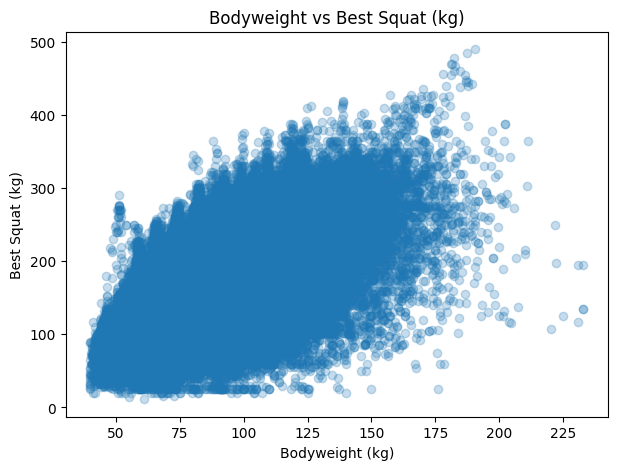

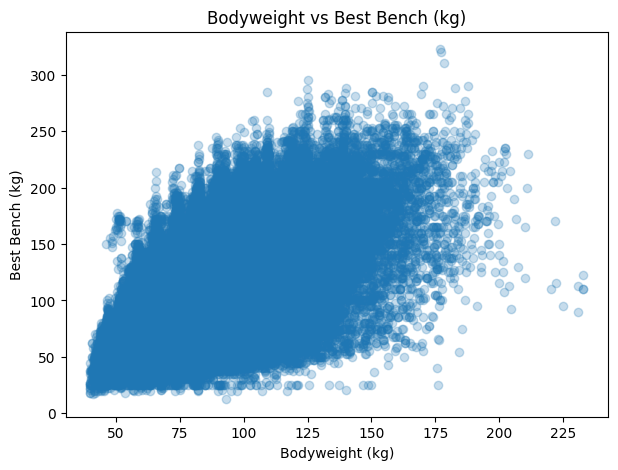

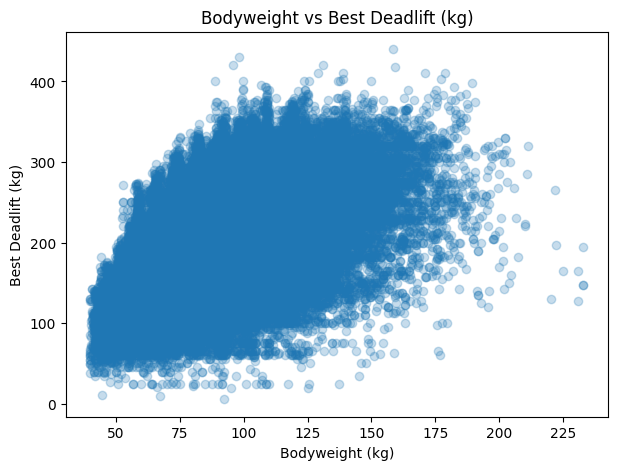

In [91]:
pairs = [
    ("Best3SquatKg", "Best Squat (kg)"),
    ("Best3BenchKg", "Best Bench (kg)"),
    ("Best3DeadliftKg", "Best Deadlift (kg)")
]

for col, y_label in pairs:
    plot_df = df_clean[["BodyweightKg", col]].dropna()

    plt.figure(figsize=(7, 5))
    plt.scatter(plot_df["BodyweightKg"], plot_df[col], alpha=0.25)
    plt.xlabel("Bodyweight (kg)")
    plt.ylabel(y_label)
    plt.title(f"Bodyweight vs {y_label}")
    plt.show()


#### Interpretation

Visual inspection of scatterplots indicates an approximately linear, positive relationship between bodyweight and performance in each of the three competition lifts. While variability increases at higher bodyweights and some extreme values are present, the overall linear trend is clear and consistent across the observed range.

Pearson correlation is appropriate because the variables are continuous, observations are paired and independent (as each competitor contributes a single observation to the dataset), and scatter plots indicate approximately linear relationships. Given the large sample size, Pearson correlation is considered robust to minor departures from normality.

---

### Pearson's Correlation (r)
Pearson correlation was used to quantify the strength and direction of the linear relationship between bodyweight and performance in each of the three competition lifts.


In [100]:
from scipy.stats import pearsonr

results = []

for lift in ["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]:
    data = df_clean[["BodyweightKg", lift]].dropna()
    r, p = pearsonr(data["BodyweightKg"], data[lift])
    results.append((lift, r, p))

corr_df = pd.DataFrame(
    results,
    columns=["Lift", "Pearson_r", "Pearson_p"]
)

corr_df


,Lift,Pearson_r,Pearson_p
0,Best3SquatKg,0.655767,0.0
1,Best3BenchKg,0.660249,0.0
2,Best3DeadliftKg,0.621069,0.0


Pearson correlation analysis revealed a strong positive association between bodyweight and performance across all three competition lifts. Bodyweight was moderately to strongly correlated with best squat (r = 0.656), bench press (r = 0.660), and deadlift (r = 0.621), with all correlations statistically significant (p < 0.001). Accordingly, we reject the null hypothesis of no linear correlation between bodyweight and performance for each lift.

These results indicate that heavier competitors tend to lift more weight in each lift, although the strength of the relationship varies slightly by lift. The bench press and squat showed slightly stronger correlations with bodyweight than the deadlift, suggesting that increases in bodyweight are most strongly associated with improvements in upper-body and squat performance. Overall, the findings support the expectation that bodyweight is an important determinant of absolute strength in powerlifting.

## 6.4 Regression Analysis: Predicting Lift Performance from Bodyweight

While correlation analysis quantifies the strength and direction of association between bodyweight and lift performance, it does not describe how much lift performance is expected to change with changes in bodyweight. Linear regression extends the correlation analysis by modeling lift performance as a function of bodyweight, allowing estimation of the average change in performance associated with a one-kilogram increase in bodyweight.

#### Purpose
This analysis uses simple linear regression to model the relationship between bodyweight (BodyweightKg) and performance in each of the three competition lifts (Best3SquatKg, Best3BenchKg, and Best3DeadliftKg). Regression is appropriate because bodyweight is a continuous predictor variable and lift performance is a continuous outcome variable. Separate regression models are fit for each lift to compare how strongly bodyweight predicts performance across lifts. For each model, a hypothesis test is conducted on the slope coefficient (β) to evaluate whether bodyweight has a statistically significant linear effect on lift performance.

**Hypothesis Test**
- Null hypothesis (H₀): β = 0 (bodyweight has no linear effect on lift performance)
- Alternative hypothesis (H₁): β ≠ 0 (bodyweight has a linear effect on lift performance)


### Assumption Considerations

Simple linear regression relies on several assumptions: independence of observations, linearity between predictor and outcome, homoscedasticity of residuals, and approximate normality of residuals. Independence is assumed based on study design, as each competitor contributes a single observation. Linearity was previously assessed using scatterplots during the correlation analysis.

Because of the large sample size, regression estimates are robust to minor departures from normality. Diagnostic plots are used to evaluate residual behavior rather than formal hypothesis tests.


In [112]:
import statsmodels.api as sm

lifts = [
    ("Best3SquatKg", "Squat"),
    ("Best3BenchKg", "Bench Press"),
    ("Best3DeadliftKg", "Deadlift")
]

reg_results = []

for y_col, lift_name in lifts:
    data = df_clean[["BodyweightKg", y_col]].dropna()

    X = sm.add_constant(data["BodyweightKg"])   # adds intercept
    y = data[y_col]

    model = sm.OLS(y, X).fit()

    reg_results.append({
        "Lift": lift_name,
        "N": int(model.nobs),
        "β₁ (kg per kg BW)": model.params["BodyweightKg"],
        "β₀": model.params["const"],
        "R²": model.rsquared,
        "p-value (β₁)": model.pvalues["BodyweightKg"]
    })

reg_df = pd.DataFrame(reg_results)
reg_df


,Lift,N,β₁ (kg per kg BW),β₀,R²,p-value (β₁)
0,Squat,248109,1.785974,14.662402,0.430030,0.0
1,Bench Press,248109,1.347963,-4.793923,0.435929,0.0
2,Deadlift,248109,1.716543,50.116106,0.385726,0.0


#### Regression Results

Across all three lifts, bodyweight was a statistically significant predictor of performance (p < 0.001). For each regression model, the null hypothesis that the slope coefficient equals zero (H₀: β₁ = 0) was rejected, indicating a statistically significant linear relationship between bodyweight and lift performance. Estimated slopes indicate that higher bodyweight is associated with higher lift totals, with the expected increase per +1 kg bodyweight differing slightly by lift. Model fit was moderate (R² ≈ 0.39–0.44), suggesting bodyweight explains a substantial portion of performance variation, while other factors (e.g., training, leverage, experience) also contribute.


### Regression Diagnostics

After fitting the regression models, diagnostic plots were examined to evaluate key regression assumptions. Specifically, residuals vs. fitted plots were used to assess linearity and constant variance, and normal Q–Q plots were used to check whether residuals are approximately normally distributed. Given the large sample size, diagnostics are used to identify major violations rather than minor deviations from ideal assumptions.


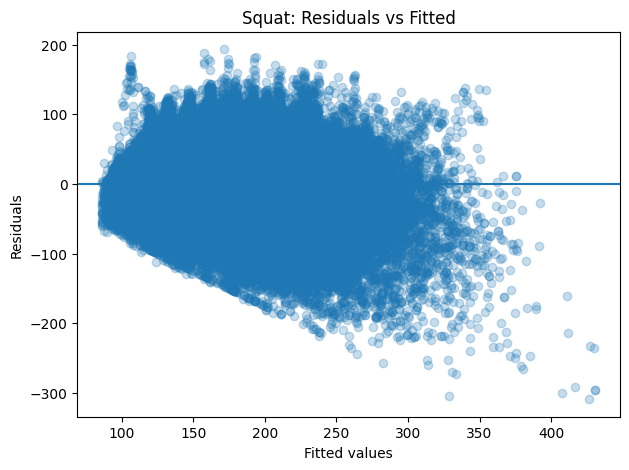

<Figure size 700x500 with 0 Axes>

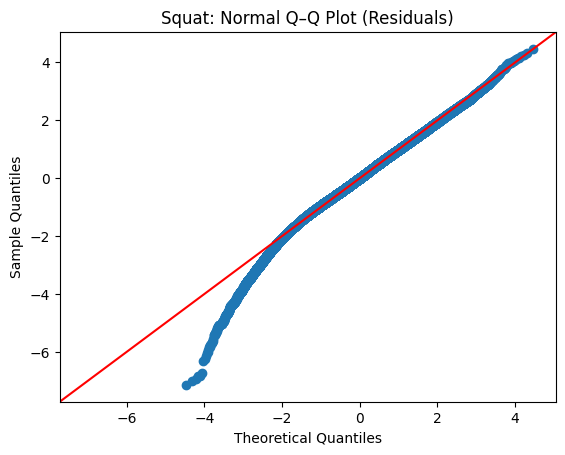

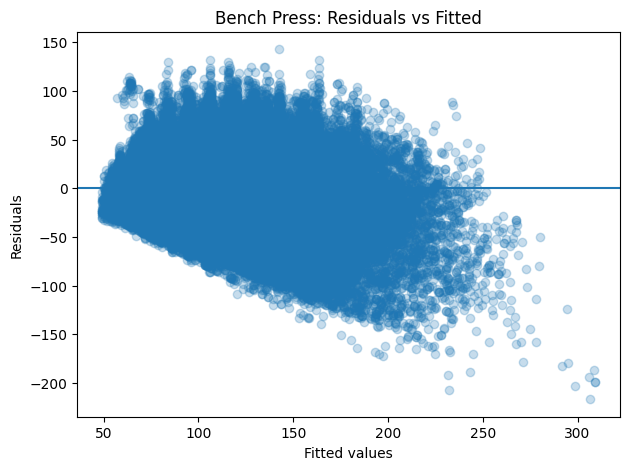

<Figure size 700x500 with 0 Axes>

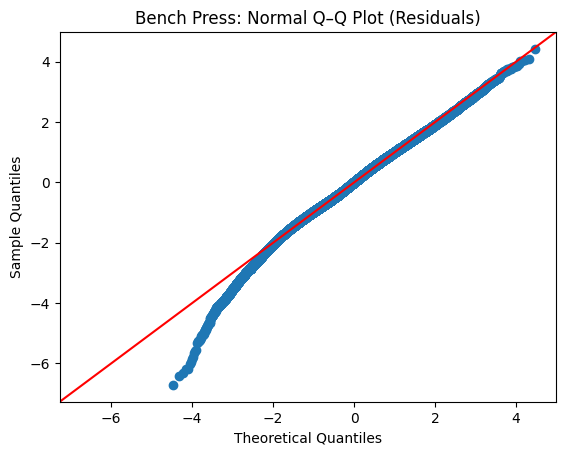

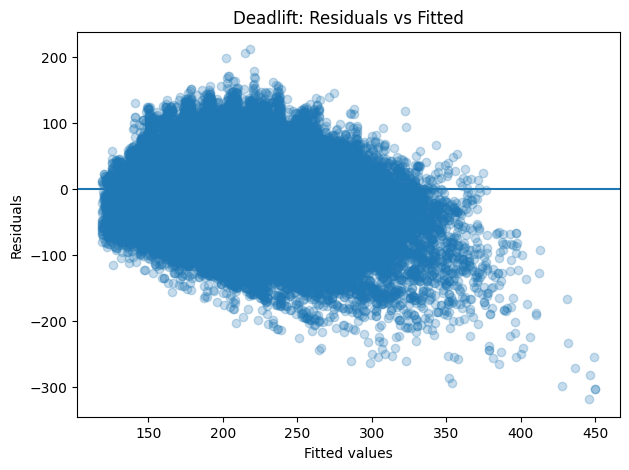

<Figure size 700x500 with 0 Axes>

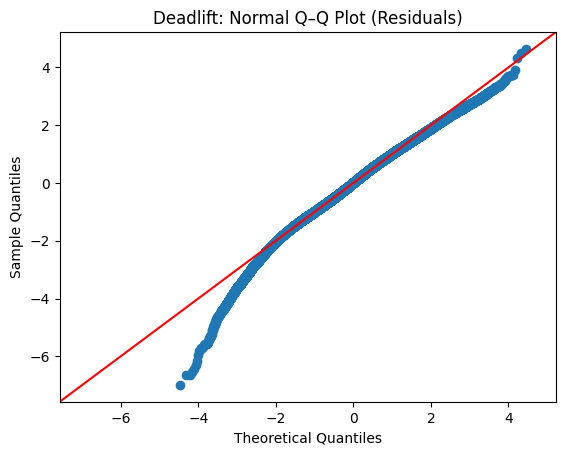

In [127]:
def run_diagnostics(df, y_col, title):
    data = df[["BodyweightKg", y_col]].dropna()

    X = sm.add_constant(data["BodyweightKg"])
    y = data[y_col]
    model = sm.OLS(y, X).fit()

    # Residuals vs Fitted
    plt.figure(figsize=(7, 5))
    plt.scatter(model.fittedvalues, model.resid, alpha=0.25)
    plt.axhline(0)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{title}: Residuals vs Fitted")
    plt.show()

    # Normal Q–Q Plot
    plt.figure(figsize=(7, 5))
    sm.qqplot(model.resid, line="45", fit=True)
    plt.title(f"{title}: Normal Q–Q Plot (Residuals)")
    plt.show()

    return model

models = {}
models["Squat"] = run_diagnostics(df_clean, "Best3SquatKg", "Squat")
models["Bench Press"] = run_diagnostics(df_clean, "Best3BenchKg", "Bench Press")
models["Deadlift"] = run_diagnostics(df_clean, "Best3DeadliftKg", "Deadlift")


### Analysis
Residuals vs. fitted plots showed residuals centered around zero with no strong systematic curvature, supporting the linearity assumption. Some increase in residual spread was observed at higher fitted values, which is expected in large observational performance datasets and did not indicate severe heteroscedasticity. Normal Q–Q plots showed deviations from perfect normality in the tails, particularly among lower residual values; however, residuals closely followed the reference line through the central range. Given the large sample size, regression estimates are robust to these minor departures, and no major violations of regression assumptions were observed.


### Summary of Regression Findings

Simple linear regression results indicate that bodyweight is a statistically significant predictor of performance for all three competition lifts. On average, increases in bodyweight were associated with higher expected lift outcomes, with estimated gains of approximately 1.8 kg per kg bodyweight for squat, 1.3 kg per kg for bench pres, and 1.7 kg per kg for deadlift. These findings directly address the first research question by quantifying the expected change in lift performance associated with increasing bodyweight.

Comparison of regression slopes and model fit suggests that **squat** and **deadlift** performance are more strongly influenced by bodyweight than bench press, although all three lifts show a meaningful positive relationship. Moderate R² values indicate that while bodyweight explains a substantial portion of performance variability, additional factors such as training history, technique, and individual biomechanics also contribute. Overall, regression analysis extends the correlation results by providing interpretable effect sizes and confirming that higher bodyweight is consistently associated with higher lift performance across competition lifts. According to this model, it appears that the Squat is most affected by changes in body weight.



---


## 10. Summary and Conclusions

This study examined competitive powerlifting performance using a cleaned subset of the Open Powerlifting Database, focusing on adult raw competitors across standard weight classes. Data preprocessing steps ensured analysis-ready records by removing implausible values, restricting to adult competitors, and retaining only variables relevant to competition outcomes. All analyses were conducted using established statistical techniques appropriate for the research questions and data structure.

Results from the independent-samples Welch’s t-test (Research Question 1) showed a statistically significant and practically meaningful difference in Wilks scores between male and female competitors. Male competitors exhibited higher average Wilks scores, with a moderate-to-large effect size, indicating that sex-based differences in relative strength persist even after accounting for bodyweight through the Wilks formula.

Welch’s one-way ANOVA addressing Research Question 2 revealed strong evidence that total weight lifted differs across competition weight classes. Mean totals increased systematically with weight class, and variability also increased among heavier classes. These findings support the validity of weight classes as meaningful performance groupings in powerlifting and confirm that absolute strength increases with bodyweight category.

Correlation analysis (Research Question 3) demonstrated moderate-to-strong positive linear relationships between bodyweight and performance in the squat, bench press, and deadlift. Heavier competitors tended to lift more weight across all three lifts, with slightly stronger correlations observed for the squat and bench press than for the deadlift. These results confirm that bodyweight is an important determinant of absolute strength, while also indicating substantial variability within weight ranges.

Linear regression analysis extended the correlation results by addressing Research Question 4 and quantifying the expected change in lift performance associated with increases in bodyweight. Bodyweight was a statistically significant predictor for all three competition lifts, with estimated increases of approximately 1.8 kg per kg bodyweight for squat, 1.3 kg for bench press, and 1.7 kg for deadlift. Comparison of regression coefficients suggests that squat and deadlift performance are more strongly influenced by bodyweight than bench press, although bodyweight alone does not fully explain performance outcomes.

Across all analyses, results were consistent with established expectations in competitive powerlifting. However, several limitations should be noted. The dataset lacks detailed information on training history, competitive experience, and technique, which likely account for additional variability in performance. Missing age data for some competitors and unequal representation across weight classes may also influence results. Finally, the large sample size increases statistical power, making it important to interpret significance alongside effect sizes and practical relevance.

Together, these findings demonstrate how different statistical techniques—group comparisons, correlation, and regression—provide complementary perspectives on powerlifting performance.
